## Data
We obtained data from GDELT. Our SQL query exports filtered data from the **GDELT event database** in BigQuery to Google Cloud Storage (GCS) in **CSV** format. The export includes events that involve actors from three specific countries (**USA**, **India**, and **China**) and limits results to reputable publishers from the **USA**, **UK**, **India**, and **China**. The query filters events occurring between **January 1, 2010**, and **December 31, 2020**.

Data and SQL query location: `countries-in-news/data`

#### Export Details:
- **URI**: The data is exported to `gs://gdelt-storage/gdelt-2024-09-30-*.csv` in Google Cloud Storage. The `*` in the URI allows the export to split into multiple files if needed (BigQuery automatically splits files larger than 1GB).
- **File Format**: The export is in CSV format.
- **Overwrite**: Existing files with the same name in the GCS bucket will be overwritten.
- **Header**: The CSV file includes headers.
- **Field Delimiter**: Fields in the CSV are separated by commas (`,`).

#### Query Breakdown:
1. **SELECT Clause**:
   - **SQLDATE**: The date of the event in the format `YYYYMMDD`.
   - **Actor1CountryCode**: The country code of the first actor involved in the event (e.g., 'USA', 'IND').
   - **Actor2CountryCode**: The country code of the second actor involved in the event.
   - **GoldsteinScale**: A numeric score representing the impact of the event (higher values represent more positive events, lower values represent more negative events).
   - **Actor1Geo_CountryCode**: The country code of the location associated with the first actor.
   - **AvgTone**: The average tone of the event, indicating how positive or negative the media coverage of the event is.
   - **SOURCEURL**: The URL of the news source reporting the event.

2. **FROM Clause**:
   - The data is being pulled from the `gdelt-bq.full.events` table, which contains global event data from the GDELT project.

3. **WHERE Clause**:
   - **Actor1CountryCode Filter**: Only events where the first actor is from the **USA**, **India**, or **China** are included.
   - **SQLDATE Filter**: The query filters events that occurred between **January 1, 2010** (`20100101`) and **December 31, 2020** (`20201231`).
   - **SOURCEURL Filter**: The query restricts events to those reported by the following reputable publishers:
     - **nytimes.com** (The New York Times)
     - **washingtonpost.com** (The Washington Post)
     - **cnn.com** (CNN)
     - **bbc.com** (BBC, United Kingdom)
     - **thehindu.com** (The Hindu, India)
     - **xinhuanet.com** (Xinhua News, China)

4. **ORDER BY Clause**:
   - The results are ordered by `SQLDATE` in descending order, meaning the most recent events are listed first.

In [31]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import re
from urllib.parse import urlparse


In [12]:
# Use glob to find all CSV files matching the pattern
csv_files = glob.glob('data/gdelt-*.csv')
print(f"{csv_files=}")

# Read each CSV file and concatenate them into one DataFrame
df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
df

csv_files=['data/gdelt-2024-09-30-000000000002.csv', 'data/gdelt-2024-09-30-000000000000.csv', 'data/gdelt-2024-09-30-000000000001.csv']


,SQLDATE,Actor1CountryCode,GoldsteinScale,Actor1Geo_CountryCode,AvgTone,SOURCEURL
0,20150814,IND,-4.0,IN,-1.546135,http://www.thehindu.com/news/national/indias-d...
1,20150814,USA,4.0,US,3.020134,http://www.nytimes.com/2015/08/14/arts/music/c...
2,20150814,USA,3.4,US,-0.496278,http://www.washingtonpost.com/news/the-fix/wp/...
3,20150814,USA,-2.0,US,-4.839956,http://www.nytimes.com/aponline/2015/08/14/us/...
4,20150814,USA,-10.0,US,-2.046649,http://www.nytimes.com/politics/first-draft/20...
...,...,...,...,...,...,...
1868061,20150815,IND,7.0,IN,-1.117318,http://timesofindia.indiatimes.com/city/mysuru...
1868062,20150815,IND,1.9,IN,-7.782101,http://www.thehindu.com/news/cities/Delhi/man-...
1868063,20150815,IND,0.0,IN,-1.419745,http://timesofindia.indiatimes.com/city/amrits...
1868064,20150815,USA,1.9,US,-3.037762,http://www.nytimes.com/2015/08/16/us/politics/...


In [13]:
df['SQLDATE'] = pd.to_datetime(df['SQLDATE'], format='%Y%m%d')

In [14]:
df['YEAR'] = df['SQLDATE'].dt.year
df['MONTH'] = df['SQLDATE'].dt.month
df['DAY'] = df['SQLDATE'].dt.day

In [15]:
(df['YEAR']<2010).sum()

0

<Axes: >

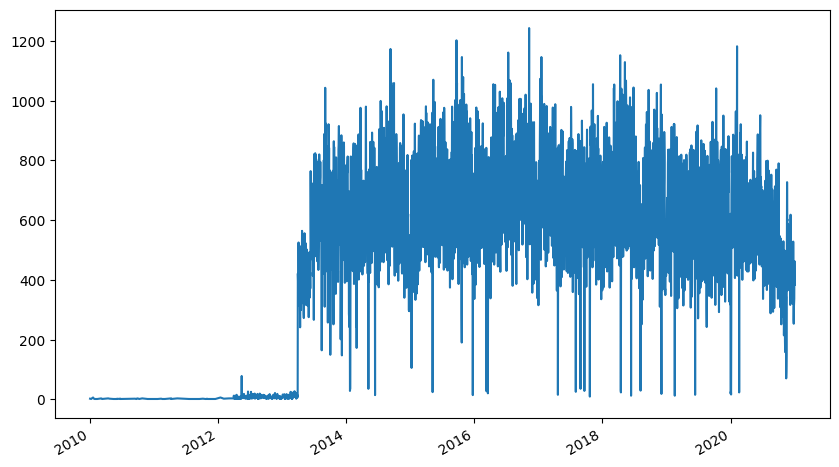

In [16]:
# plot timeline of articles
plt.figure(figsize=(10, 6))
df['SQLDATE'].value_counts().sort_index().plot()

## Frequency Table

In [17]:
df['Actor1CountryCode'].value_counts()

USA    1033163
IND     460437
CHN     374466
Name: Actor1CountryCode, dtype: int64

In [32]:
# Function to extract main domain from the URL (ignoring subdomains)
def extract_main_domain(url):
    # Parse the URL to extract the netloc (domain)
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    
    # If domain is empty, return None (handle poorly formatted URLs)
    if not domain:
        return None

    # Use regex to clean and extract just the main domain, ignoring subdomains
    main_domain = re.search(r'([a-zA-Z0-9-]+\.[a-zA-Z]{2,})$', domain)
    if main_domain:
        return main_domain.group(1)  # Return the main domain (e.g., 'nytimes.com')
    
    return None

In [34]:
df['Source'] = df['SOURCEURL'].apply(extract_main_domain)

In [35]:
df['Source'].value_counts()

washingtonpost.com    543967
indiatimes.com        371609
nytimes.com           291462
thehindu.com          252163
xinhuanet.com         224152
scmp.com              148051
bbc.com                36653
sglinks.com                9
Name: Source, dtype: int64

In [42]:
df_plot = df.groupby(['Actor1CountryCode', 'Source'])[['Actor1CountryCode', 'Source']].value_counts().reset_index()
df_plot.columns = ['Actor1CountryCode', 'Source', 'Articles']
df_plot

,Actor1CountryCode,Source,Articles
0,CHN,bbc.com,6669
1,CHN,indiatimes.com,27982
2,CHN,nytimes.com,27523
3,CHN,scmp.com,101510
4,CHN,sglinks.com,3
5,CHN,thehindu.com,22986
6,CHN,washingtonpost.com,28027
7,CHN,xinhuanet.com,159766
8,IND,bbc.com,925
9,IND,indiatimes.com,277931


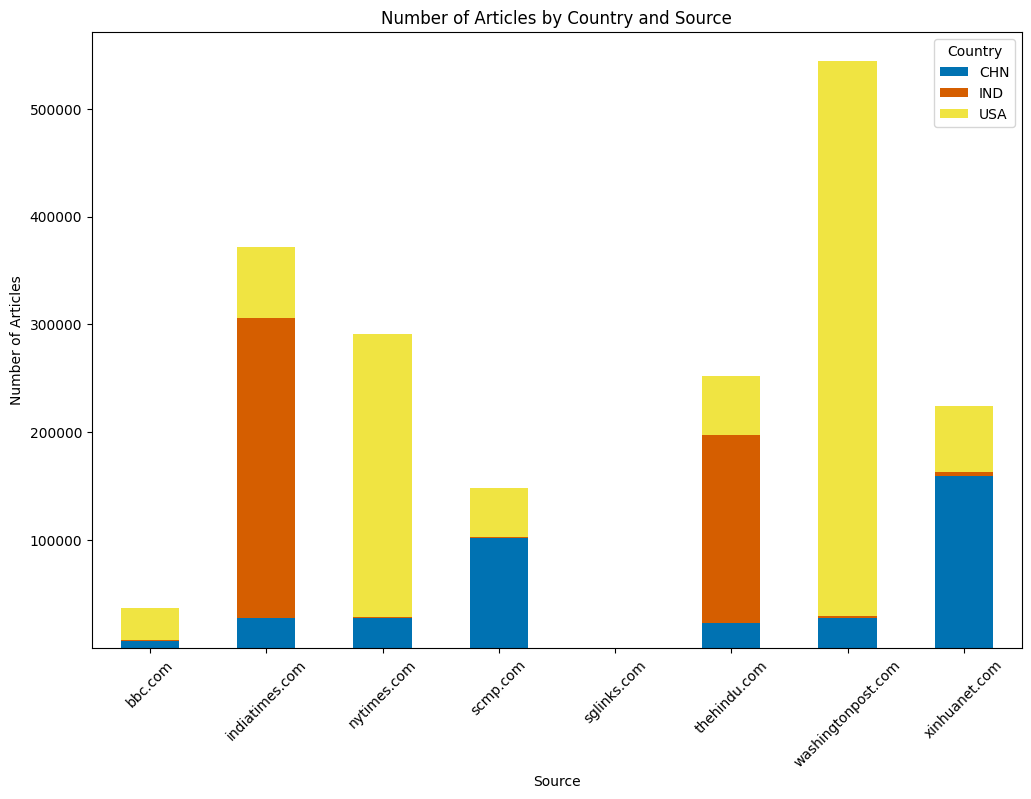

In [46]:
# Pivot the data for stacked bar plot
df_pivot = df_plot.pivot(index='Source', columns='Actor1CountryCode', values='Articles')

# Plot the stacked bar chart
df_pivot.plot(kind='bar', stacked=True, figsize=(12, 8), color=['#0072B2', '#D55E00', '#F0E442'])

plt.title('Number of Articles by Country and Source')
plt.xlabel('Source')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.legend(title='Country')
# plt.show()

plt.savefig('articles_by_country_and_source.pdf')

## Export Complete Data

In [48]:
df.to_feather('data/gdelt.feather')